<a href="https://colab.research.google.com/github/EleonoraBartolomucci/Fairness/blob/master/exposure.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import requests
from lxml import html
import pandas as pd
import json
import csv
import numpy as np
import os
import pickle
import random
import datetime
import math
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials


import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import SpectralClustering
from sklearn.cluster import KMeans

from sklearn.cluster import DBSCAN
from sklearn import metrics
from sklearn.datasets import make_blobs
from sklearn.preprocessing import StandardScaler

In [0]:
from google.colab import drive 
drive.mount('/content/gdrive')


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:

root_path = 'gdrive/My Drive/Tesi/Fairness/data/fairness_data/'


In [0]:
# CONSTANTS
business_headers = ['index', 'business_id', 'name', 'address', 'city', 'state', 'postal_code', 'latitude', 'longitude', 'stars', 'review_count', 'is_open', 'attributes', 'categories', 'hours']
FOLDER = {'WbJ1LRQdOuYYlRLyTkuuxw':
            {'FID_RANKING': '1U0Ml5puObfOk3qHCKhO9bQ06WyhJoffW',
             'FID_G1': '1cauvqKXzF5VhiveP84aL3U0oDrXP32XV',
             'FID_G2': '1vC1fc2owpCis_PTl1ABKT6BfG6-2yoiJ',
             'FID_G3': '1_iKbmJkBwWEEIIh73UvR431Ss6xnGb2f',
             'FID_G4': '1m_feamMvpx5B5mTe_lH6qlhoZFEpwlSs',
             'FID_G5': '1qJgFbR4FUX5t7O9h5cHgp6aE6lpfbdOs',
             'FID_G6': '1BSQrghVusO_eNbe10fFE4-bVfRK8ly0y',
             'FID_G7': '1fJD4WIErH-u5plesyTePCAQ3IyfjoOKf',
             'FID_G8': '1fD_fdl-1KAzXCjPOsEvFOZS3u354XhLL'
             },
          'T2tEMLpTeSMxLKpxwFdS3g':
            {'FID_RANKING': '136FZ0Y90Zx-4UYDyW50cX8zUa_DhN3XS',
             'FID_G1': '1eiju1aTzsRi4QQZ8XrSouqcLtFSN-tbj',
             'FID_G2': '1VuU8MAcXgN_E85q9SH_P1HsHVkeJakwH',
             'FID_G3': '1L240ycUElvmF0R4l8PbnuoBbqQY6q1og',
             'FID_G4': '1S4oTf-ZSD8q9aTOjrDEA2KeNJ99uh-2n',
             'FID_G5': '1u9ZFeCwmol1uXRH-l8djJ2hst0B01VI3',
             'FID_G6': '19TgwV3uHOtDDJ0a8krpvLUeooe9rhQFJ',
             'FID_G7': '11YpFHw34cDglPD87W8yWvRM1VAOWXPtF',
             },
          'ALwAlxItASeEs2vYAeLXHA':
            {'FID_RANKING': '12zXi3XyQaNgukGHW_805cyrkHhSdF7Df',
             'FID_G1': '1NB-isOm1cDArAlwIMDMou1Q_XAap09KA',
             'FID_G2': '1ELMUBbKGryblHDnbh7ghiIgMdZ48pBG1',
             'FID_G3': '1QZ90pwDjBoaU41P8wP8v_I9tsuhObEUP',
             'FID_G4': '1MXivbV9VGB0vBGGuLhYu0zJlpv6O-2Xb',
             'FID_G5': '1bTetFx3Jhy5QbRKYGV09muMy7D1NKmJT',
             'FID_G6': '1F_7bdMS5MW4sIpyUbDz62ZTYJtHoouGG',
             'FID_G7': '1uRFceNIlYk5vQXEGd2H6yanrlwrSIM9V',
             },
          'OVTZNSkSfbl3gVB9XQIJfw':
            {'FID_RANKING': '1ZyNQavpG0akr3ca3PJjjl_D89IA5wlcc',
             'FID_G1': '1kQkAi_9V3mSld1LlP50j6uw0bwqnkLrR',
             'FID_G2': '1hGR4eZiP3Q9Etn7RdlY58IsNsTMMTydz',
             'FID_G3': '1YcAPHxioFpiVXWndO5tK17US1h36cWgK',
             'FID_G4': '1NxzzH0l18fGaO4bZ35D9NMq2CeW5BRVP',
             'FID_G5': '1HC1wZGPtbb8UvRlfbGoHl_ijl3G67Ei4',
             'FID_G6': '1J_15pO-CFbHR_0YsHK5kDnKp49kDL0kZ',
             'FID_G7': '1RTwCqhYzB3djzpe3-uwbQ3Ur5P8YoECa',
             },
          'Sovgwq-E-n6wLqNh3X_rXg':
            {'FID_RANKING': '1EZqvt9x5PN07BgUad1RtNIUXTVqujA0g',
             'FID_G1': '1pkUEBYeZ66GfIvXoTkzZ28gGFlZNWmEq',
             'FID_G2': '1lJzHAfBlvL9_EgNizH4vnyPTn-j-Vbrx',
             'FID_G3': '1NRYqjUsQJTwgB0JXtcCx7lQErirMH1TK',
             'FID_G4': '1nLtZbS0NGXKAs6aETNs7EWasNs8omaw6',
             'FID_G5': '14w-jVhOuod3s_EYSipvS92SPx_3zT_FD',
             'FID_G6': '1tbUyiamFmyAoeA3W6j51x97h3MjUSVsd',
             'FID_G7': '1TNAmibHwJHkvNajHhRffN1gEY0-QnBZH',
             },
          'j5nPiTwWEFr-VsePew7Sjg':
            {'FID_RANKING': '18bQVXYZ03vIpfEFLPh8I2i7cPTlokGxv',
             'FID_G1': '1U8STZ7irZLPcUpP1ALR6QYIFnoXB2tbE',
             'FID_G2': '1xScKc0_DlnQZucHLeb26hLqpgjqMA3RH',
             'FID_G3': '1JFYl2eKtDyWbsyVdBpTXsvPn2h6MO3Cr',
             'FID_G4': '1aFYpJmymdnHxquuqbbMwXzN5wG-3Zf2O',
             'FID_G5': '1NfHlsBTk87jscmZfagtnd--kcdpy8t_8',
             'FID_G6': '1b88afNqrZSRptYA0pL3lCEV49mFaEP6Q',
             'FID_G7': '15rDbY-MTUBVjHxOedbenZIjTxQ_wEAZW',
             },
          'aiX_WP7NKPTdF9CfI-M-wg':
            {'FID_RANKING': '1nl6A997UnuR5ceYRZS1242JJCvK',
             'FID_G1': '1hrssLlhPmnS48yVxXpwBBIuhL1YdDNhj',
             'FID_G2': '1shLPc3aUsVaxeZhZ_SvDS3agPFlMw1dn',
             'FID_G3': '13eUtYFVp-KKjxV6-mhCsxQGHkKFOgB82',
             'FID_G4': '1nQVPHZT4sHpBXD32qX_x41VywkmyppFj',
             'FID_G5': '1gJpfGhb721Q64gynq4jSGMis5pDA7qAx',
             'FID_G6': '1WbZvolaSwambWOKHx4v4eFIV-KUzygGF',
             'FID_G7': '1IWyQpgMjLny2JTbw0nUuHkNRPV5CCA_A',
             },
          'e4NQLZynhSmvwl38hC4m-A':
            {'FID_RANKING': '1K566Y5Q2N6Lw7S6yDicKC_R-zFVRqnFr',
             'FID_G1': '1RNxub2faGfc4NAFvau5SsMADAzBlQd2j',
             'FID_G2': '16tjv4k5CJSOxwgvC0wDJU67MEjRaw_0o',
             'FID_G3': '1p-9HrVncD_FZOxO0YzHiY7KTe47ugSTQ',
             'FID_G4': '1qGpECepAyJjqyfPx8Q94odPOCHbOixtZ',
             'FID_G5': '15AGLE1YT0v8tQ3r6i6k7j5XaNORToUct',
             'FID_G6': '1nNbAPulqJCzO6urHNsqc4qzSM7Yih8uk',
             'FID_G7': '1o9Ew39-Q9VO3wjEyv4qGJ9YlfRmkzTed',
             },
          'S-oLPRdhlyL5HAknBKTUcQ':
            {'FID_RANKING': '1FJqfJgaJinXS3oIvdA53FMuO9O7bCDVn',
             'FID_G1': '1CcLHVEA41AgSzJKl37YlcJKf-o5NaCUo',
             'FID_G2': '1j-lp1gcu6YGTwcOV4aYiY7dh2G9_TL6J',
             'FID_G3': '1I-Qn9oz4VopXbpj5i8_iqLvcSp8jpb2_',
             'FID_G4': '1gsS9uFbRyI18ifF5yLp20WHhP66gdr57',
             'FID_G5': '1LJIVm9tCZMcgzBkGilYem0nqKoUHpdpX',
             'FID_G6': '1syB0wF48fiSo0_uW9dedS-ZlFfXUv1B8',
             'FID_G7': '1cBPjBprJ19RxI6-Bcpb-Fifv0s1bQSV2',
             }
        }


In [0]:
# READ JSON
def read_json(json_path):
  data = []
  with open(json_path, "r") as my_file: 
    for line in my_file:
      line_json = json.loads(line)
      data.append(line_json)
  return data


# PARSE JSON IN CSV
def json2csv(csv_path, json_path):
  data = read_json(json_path)
  df = pd.DataFrame(data)
  df.to_csv(csv_path)

In [0]:
# AUTHENTICATE IN GOOGLE DRIVE
def authenticate():
  auth.authenticate_user()
  gauth = GoogleAuth()
  gauth.credentials = GoogleCredentials.get_application_default()
  drive = GoogleDrive(gauth)
  return drive
drive = authenticate()

In [0]:
def upload_file(filename, folder_id):
  drive = authenticate()
  fileList = drive.ListFile({'q': "'" + folder_id + "' in parents and trashed=false"}).GetList()
  drive_file = drive.CreateFile({'title': filename, 'parents': [{'id': folder_id}]})
  # Check if file already exists in Google Drive (prevents duplicates)
  for file in fileList:
      if file['title'] == filename:  # The file already exists, then overwrite it
          fileID = file['id']
          drive_file = drive.CreateFile({'id': fileID, 'title': filename, 'parents': [{'id': folder_id}]})

  # Create a local copy of user picture
  # Already created!

  # Upload user picture on Google Drive
  drive_file.SetContentFile(filename)  # path of local file content
  drive_file.Upload()  # Upload the file.
  
  # Delete local user pictures
  #if os.path.exists(filename):
  #    os.remove(filename)
  #else:
  #    print("The file does not exist")

def set_file_destination(lst, method, id):
  if lst == ['review_count']:
    return FOLDER[id]['FID_G1']
  if method == 'kmeans':
    if lst == ['review_count', 'fans', 'average_stars', 'useful', 'funny', 'cool']:
      return FOLDER[id]['FID_G2']
    if lst == ['loc1', 'loc2', 'loc3']:
      return FOLDER[id]['FID_G3']
    if lst == ['age', 'gender', 'ethnicity']:
      return FOLDER[id]['FID_G4']
    if lst == ['fans']:
      return FOLDER[id]['FID_G6']
    if lst == ['useful','funny', 'cool']:
      return FOLDER[id]['FID_G7']
  if method == 'dbscan':
    return FOLDER[id]['FID_G8']


In [0]:
# DOWNLOAD user.json FROM DRIVE
users_dataset_id = '1JokoV68YD5Iq2l4Y_IV2RJzBpD_mSCyq'  # FILE ID, got on google drive with condivision link
download = drive.CreateFile({'id': users_dataset_id})
download.GetContentFile('user.json')
users = read_json('user.json')
users = pd.DataFrame(users)

In [0]:
# DOWNLOAD business.json FROM DRIVE
business_dataset_id = '1Qoy132gb205xAIFjkBbZ2CyYDeaz9yqU'  # FILE ID, got on google drive with condivision link
download = drive.CreateFile({'id': business_dataset_id})
download.GetContentFile('business.json')
business = read_json('business.json')
business = pd.DataFrame(business)

In [0]:
# DOWNLOAD review.json FROM DRIVE
review_dataset_id = '1mW1WbpMFjN0qQpLnM-R_TzNpAkFsBLHQ'  # FILE ID, got on google drive with condivision link
download = drive.CreateFile({'id': review_dataset_id})
download.GetContentFile('review.json')
reviews = read_json('review.json')
reviews = pd.DataFrame(reviews)

In [0]:
# DOWNLOAD DEMOGRAPHICS
id_list = ['WbJ1LRQdOuYYlRLyTkuuxw','T2tEMLpTeSMxLKpxwFdS3g','ALwAlxItASeEs2vYAeLXHA',
          'OVTZNSkSfbl3gVB9XQIJfw','Sovgwq-E-n6wLqNh3X_rXg','j5nPiTwWEFr-VsePew7Sjg',
          'aiX_WP7NKPTdF9CfI-M-wg', 'e4NQLZynhSmvwl38hC4m-A']
#id_list = ['WbJ1LRQdOuYYlRLyTkuuxw']
file_id_list = {'WbJ1LRQdOuYYlRLyTkuuxw':['13amOFvuku27snF8mea8Yp7rH36Mve42N',
                                          '1VskD_0Ijwe3_fzVbgYqK9Bk-YOCK046t',
                                          '1uuA0QH-DJklvtiekxS-7yaXfKRi9ux06'],
                'T2tEMLpTeSMxLKpxwFdS3g':['11fM_aHYkCLQ2z3g7Z76aZZ3cAsIrpezN',
                                          '1TPexYC2YHq_8ywZSuRRIJkrUCstwoxSp',
                                          '1ObvjBbxRNIp1vOQipUGZxZEi_eQH7kJQ'],
                'ALwAlxItASeEs2vYAeLXHA':['1crTNpDR2VjBdGSgavIvN4QNhwTUR3-Bk',
                                          '1sJOKR7-__9dKJG0ewVQyfmV6i_dLpcRk',
                                          '1tgJnMW0ZImx1vbDzWpvFBRX0FJu1Kdbt'],
                'OVTZNSkSfbl3gVB9XQIJfw':['1Vmkzpdi_0m9CGcyp5ggeNsUsueBzqufH',
                                          '12aiPnkvuUtyc8B2UmJEu2BpeXVYbPumF',
                                          '1qecYhCBytq1Z6lm_ueCWIuithvRG0wIq'],
                'Sovgwq-E-n6wLqNh3X_rXg':['1VVePrvWR7e5XkRmhp5Q5qOPXPskVmnnt',
                                          '1fSqJYcczjUsbryfI7ekeqANaz-xD4PFT',
                                          '1R5GFYo2c2YC_AOB9G0pdOfROTyglePDI'],
                'j5nPiTwWEFr-VsePew7Sjg':['1txkAzGKMRjXku18rv9222q-FqVo42A9o',
                                          '1e8iSM3SpyB2Y_h6rzRSVVgphjHEIJnZU',
                                          '16H267f71Y_1l8O5-n5JlF5v8GNpnt_kc'],
                'aiX_WP7NKPTdF9CfI-M-wg':['1VrVgBoJp5cRVMH4I-5uKvdF3b-PSfbmL',
                                          '1f7T7ksdCCGxhVF_RJU9zu38-r8aTTJcD',
                                          '1ApgXp06OyhQSgFg4pyxaH_vF6djUFmNc'],
                'e4NQLZynhSmvwl38hC4m-A':['1yYG8ftjE1i9prP61ej5EdGfJDlweiK3C',
                                          '1KSdN24eXC-Bnk2_mTQR6oNaGll1KP5hO',
                                          '1PA2eYsYj2bj4Mo7ofbnvbQgYjmd2SwRG'],
                'S-oLPRdhlyL5HAknBKTUcQ':['1qcX9pGfmogOokbBOPnZY-NbroolffAlg',
                                          '1YVdSND3VNit4ieORXC_mVzcv4mphGUnY',
                                          '1XrZViuuarqibJmaURcb0SHU5nd_3zGpo']}
for business_id in id_list:
  df = pd.DataFrame()
  for file_id in file_id_list[business_id]:
    download = drive.CreateFile({'id': file_id})
    download.GetContentFile('demographics_' + business_id + '.csv')
    df_temp = pd.read_csv('demographics_' + business_id + '.csv')
    df = df.append(df_temp)
  df = df.drop_duplicates('id',keep='first').reset_index(drop=True)
  df = df.rename(columns={'id':'user_id'})
  df.to_csv('demographics_' + business_id + '.csv')
  upload_file('demographics_' + business_id + '.csv',FOLDER[business_id]['FID_G4'])

In [0]:
# FILTER RESTAURANTS
is_restaurant = business['categories'].str.contains('Restaurants', regex=False, na=False)
restaurants = business[is_restaurant]

# Filter closed restaurants
restaurants = restaurants[restaurants['is_open'] == 1]

# Order restaurants by review_count
restaurants = restaurants.sort_values('review_count')

restaurants.to_csv('restaurants_input.csv')
# NOW CHOOSE THE RESTAURANTS AND SAVE THEIR IDS INTO TXT FILE

In [0]:
# EXEC IN LOCAL THE DOWNLOAD OF REVIEW RANKINGS OF EACH RESTAURANT
# UPLOAD CSV IN COLAB

In [0]:
############################# EXECUTE IN LOCAL (if not blocked by yelp) #############################################
def get_ranking_from_call(url_business, lang, sort, query):
    headers = [{"name": "Accept", "value": "*/*"}, {"name": "Accept-Encoding", "value": "gzip, deflate, br"},
               {"name": "Accept-Language", "value": "it-IT,it;q=0.8,en-US;q=0.5,en;q=0.3"},
               {"name": "Connection", "value": "keep-alive"},
               {"name": "Content-Type", "value": "application/x-www-form-urlencoded; charset=utf-8"}, {"name": "Cookie",
                                                                                                       "value": "qntcst=D; hl=en_US; wdi=1|3C26116D69138F61|0x1.78d019f71a444p+30|a7756ff94751d3a9; _ga=GA1.2.3C26116D69138F61; location=%7B%22city%22%3A+%22New+York%22%2C+%22state%22%3A+%22NY%22%2C+%22country%22%3A+%22US%22%2C+%22latitude%22%3A+40.713%2C+%22longitude%22%3A+-74.0072%2C+%22max_latitude%22%3A+40.8523%2C+%22min_latitude%22%3A+40.5597%2C+%22max_longitude%22%3A+-73.7938%2C+%22min_longitude%22%3A+-74.1948%2C+%22zip%22%3A+%22%22%2C+%22address1%22%3A+%22%22%2C+%22address2%22%3A+%22%22%2C+%22address3%22%3A+null%2C+%22neighborhood%22%3A+null%2C+%22borough%22%3A+null%2C+%22provenance%22%3A+%22YELP_GEOCODING_ENGINE%22%2C+%22display%22%3A+%22New+York%2C+NY%22%2C+%22unformatted%22%3A+%22New+York%2C+NY%2C+US%22%2C+%22accuracy%22%3A+4.0%2C+%22language%22%3A+null%7D; xcj=1|Ptt9P03gfc75x_PBT9zmqCkUuSuyB7PR-wWUBvABNi4; __qca=P0-60561249-1581956668708; G_ENABLED_IDPS=google; __cfduid=db8764ff59d8028a6c2e1b214867927d81583160194; _gid=GA1.2.2014867238.1583835527; bse=05dcd9d5de304ef0b1d9a76fa768b10f; sc=8a1ca0dbc2; pid=505721aa4569e7bb"},
               {"name": "Host", "value": "www.yelp.com"},
               {"name": "Referer", "value": "https://www.yelp.com/biz/noche-de-margaritas-new-york"},
               {"name": "TE", "value": "Trailers"}, {"name": "User-Agent",
                                                     "value": "Mozilla/5.0 (X11; Ubuntu; Linux x86_64; rv:73.0) Gecko/20100101 Firefox/73.0"},
               {"name": "X-Requested-By-React", "value": "true"},
               {"name": "X-Requested-With", "value": "XMLHttpRequest"}]
    headers_ok = {}
    for header in headers:
        temp = {
            header['name']: header['value']
        }
        headers_ok.update(temp)

    x = 0
    reviews_list = []
    position = 1
    url = url_business + "/review_feed?rl=" + lang + "&sort_by=" + sort + "&q=" + query

    while 1:
        if x == 0:
            page_load = requests.get(url + '&start=', headers=headers_ok)
        else:
            page_load = requests.get(url + '&start=' + str(x), headers=headers_ok)
        print(page_load)
        x = x + 20
        reviews = page_load.json()['reviews']
        # print(json.dumps(reviews, indent=4, sort_keys=True))
        if not reviews:
            break
        for review in reviews:
            reviews_list.append((position, review['userId'], review['user'],#['reviewCount'],
                                 datetime.datetime.strptime(review['localizedDate'], '%m/%d/%Y')))
            position = position + 1
    df_reviews = pd.DataFrame(reviews_list, columns=["position", "user_id", "user", "date"])
    return df_reviews


def retrieve_rankings(business_id):
    df_rel_ranking = get_ranking_from_call("https://www.yelp.com/biz/" + business_id, "en", "relevance_desc", "")
    df_date_ranking = df_rel_ranking.sort_values(by=['date']).reset_index(drop=True)
    df_date_ranking['position'] = df_date_ranking.index + 1
    df_rand_ranking = df_rel_ranking.sample(frac=1).reset_index(drop=True)
    df_rand_ranking['position'] = df_rand_ranking.index + 1

    df_rel_ranking.to_csv("rel_ranking_" + business_id + ".csv")
    df_date_ranking.to_csv("date_ranking_" + business_id + ".csv")
    df_rand_ranking.to_csv("rand_ranking_" + business_id + ".csv")


rest_ids = []

with open('rest_ids.txt', 'r') as f:
  for line in f:
    rest_ids.append(line[:-1])

print(rest_ids)
for id in rest_ids:
    retrieve_rankings(id)

In [0]:
# JOIN USER FROM YELP WITH USER FROM DATASET AND PRINT LOST USERS
def filter_user_from_dataset(df, users):
  df = df.rename(columns={'Position':'position','User_Id': 'user_id',
                          'Date':'date'})
  df = df[['position','user_id','date']]
  df_merged = df.merge(users, on='user_id')
  total_review = df['position'].max()
  print('Utenti persi: totali ' + str(total_review) + ' - utenti nel dataset ' +
        str(len(df_merged.index)) + ' = ' + str(total_review - len(df_merged.index)))
  df_merged['position'] = df_merged.index + 1

  cols = df_merged.columns.tolist()

  df_merged = df_merged[['position', 'user_id', 'date', 'fans', 'average_stars', 'review_count']]

  return df_merged

In [0]:
# ADD REVIEW INFO IN RANKING DATAFRAME
def integrate_review_info(df, reviews, business_id):
  business_reviews = reviews[reviews['business_id'] == business_id]
  df_merged = business_reviews.merge(df, on='user_id')
  del df_merged['date_y']  # it's date from yelp website (not updated in dataset)
  df_merged = df_merged.rename(columns={'date_x':'date'})
  # drop duplicates reviews from same user
  df_merged = df_merged.sort_values('date').drop_duplicates('user_id',keep='last')
  df_merged = df_merged.sort_values(by=['position']).reset_index(drop=True)
  print('Review perse: ', len(df.index) - len(df_merged.index))
  df_merged['position'] = df_merged.index + 1

  df_merged = df_merged[['position', 'user_id', 'review_id', 'date', 'text', 'fans', 'average_stars', 'review_count', 'business_id']]
  
  return df_merged

In [0]:
# ADD USER DATA TO GROUP USERS
def create_vectors(df_users, reviews, business, business_id, list_of_attributes, method):
  vectors = df_users[['user_id', 'review_count', 'fans' , 'average_stars']]
  vectors["useful"] = np.NaN
  vectors["funny"] = np.NaN
  vectors["cool"] = np.NaN
  vectors["loc1"] = np.NaN
  vectors["loc2"] = np.NaN
  vectors["loc3"] = np.NaN
  for index, user in vectors.iterrows():
    print(index)
    # TOP THREE LOCATION
    location_list = get_top_three_loc(user, reviews, business)
    i = 0
    while i < len(location_list):
      vectors.loc[index, 'loc'+str(i+1)] = location_list[i]
      i = i + 1

    # USEFUL FUNNY COOL
    useful, funny, cool = get_details_user(user, reviews)
    vectors.loc[index, 'useful'] = useful
    vectors.loc[index, 'funny'] = funny
    vectors.loc[index, 'cool'] = cool

  # DEMOGRAPHICS
  vectors = get_demographics(vectors, business_id)
    
  # UPLOAD VECTORS IN DRIVE
  destination = set_file_destination(list_of_attributes, method, business_id)
  vectors.to_csv('user_vectors_' + business_id + '.csv')
  upload_file('user_vectors_' + business_id + '.csv',destination)
  return vectors


def get_demographics(vectors, id):
  df_demographics = pd.read_csv('demographics_' + id + '.csv')
  new_vectors = pd.merge(vectors, df_demographics, on='user_id', how='left')
  return new_vectors


def get_details_user(user, reviews):
  user_id = user['user_id']
  user_reviews = reviews[reviews['user_id'] == user_id]
  return user_reviews['useful'].sum(), user_reviews['funny'].sum(), user_reviews['cool'].sum()


def get_top_three_loc(user, reviews, business):
  user_id = user['user_id']
  user_reviews = reviews[reviews['user_id'] == user_id]
  result = user_reviews.merge(business, on='business_id')
  top_loc = result['state'].value_counts().index.tolist()[:3]
  top_zip = []
  for location in top_loc:
    # exclude postal_code of Canada, that is strings
    temp_list = result[result['state']==location]['postal_code'].value_counts().index.tolist()
    if temp_list != []:
      temp_list = [elem for elem in temp_list if str(elem).isdigit()]
      if temp_list != []:
        top_zip.append(int(str(temp_list[0])[:3]))
  return top_zip

In [0]:
def compute_groups_percents(df_groups, N_of_groups):
  total = len(df_groups.index)
  percents = []
  i = 0
  while i < N_of_groups:
    current_length = len(df_groups[df_groups['group_id'] == i].index)
    percents.append((current_length/total)*100)
    i = i + 1
  print(percents)
  return percents



++++++++++++++++ GROUPS CREATION ++++++++++++++++++

Estimated number of clusters: 9
Estimated number of noise points: 0
Estimated number of clusters: 9
Estimated number of noise points: 0
Estimated number of clusters: 7
Estimated number of noise points: 2
Estimated number of clusters: 7
Estimated number of noise points: 2
Estimated number of clusters: 7
Estimated number of noise points: 4
Estimated number of clusters: 7
Estimated number of noise points: 5
Estimated number of clusters: 7
Estimated number of noise points: 6
Estimated number of clusters: 7
Estimated number of noise points: 7
Estimated number of clusters: 6
Estimated number of noise points: 15
Estimated number of clusters: 6
Estimated number of noise points: 15
Estimated number of clusters: 6
Estimated number of noise points: 18
Estimated number of clusters: 6
Estimated number of noise points: 18
Estimated number of clusters: 5
Estimated number of noise points: 29
Estimated number of clusters: 5
Estimated number of noise

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


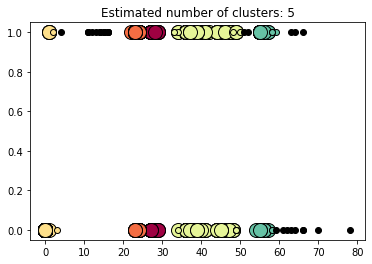

[4.729266620973269, 7.676490747087046, 51.61069225496916, 30.431802604523643, 3.495544893762851]
                     user_id  group_id
0     mCrhj_CG3_pOmDFcfKotRQ       0.0
1     VlcasgkqiTuPi-nVT7rEtw       1.0
2     xDl9ZF3SckkZde_48W6WeA       2.0
3     TKwzreBMGFbu9zN6taeVLA       2.0
4     GWOf1oB2mTalRY_A-EjSiQ       2.0
...                      ...       ...
1454  03_OcS8SbBcO4RTx_jYAUw       2.0
1455  vpCdKYNXUjs5o-tVSmwGAg       2.0
1456  vVBNWuQO9m5Utm69PGoRCw       2.0
1457  h7zHYM8LbPWmXx0ZEqOOAw       2.0
1458  4wbMeUS9tp2QGqyNhj3YTg       2.0

[1459 rows x 2 columns]

++++++++++++++++ EXPOSURE CALCULATION ++++++++++++++++++

----------------DEMOGRAPHIC PARITY EXP------------------

------------Ranking by Yelp filter:------------

  group_id  exposure
0        0   0.19185
1        1  0.172226
2        2   0.15808
3        3   0.17314
4        4  0.164986


------------Ranking by Date:------------

  group_id  exposure
0        0  0.167258
1        1  0.163502
2        2 

KeyboardInterrupt: ignored

In [122]:
# PIPELINE
N_of_groups = 5
#id_list = ['WbJ1LRQdOuYYlRLyTkuuxw','T2tEMLpTeSMxLKpxwFdS3g','ALwAlxItASeEs2vYAeLXHA',
#          'OVTZNSkSfbl3gVB9XQIJfw','Sovgwq-E-n6wLqNh3X_rXg','j5nPiTwWEFr-VsePew7Sjg',
#          'aiX_WP7NKPTdF9CfI-M-wg', 'e4NQLZynhSmvwl38hC4m-A']
id_list = ['WbJ1LRQdOuYYlRLyTkuuxw']

#list_of_attributes = ['review_count']
#list_of_attributes = ['review_count', 'fans', 'average_stars', 'useful', 'funny', 'cool']
#list_of_attributes = ['loc1', 'loc2', 'loc3']
list_of_attributes = ['age', 'gender', 'ethnicity']
#list_of_attributes = ['fans']
#list_of_attributes = ['useful', 'funny', 'cool']
#list_of_attributes = ['age', 'ethnicity']
method = 'dbscan'

for id in id_list:
  authenticate()
  #df_rel_ranking, df_date_ranking, df_rand_ranking = pipeline1(id, users, reviews)
  df_rel_ranking = pd.read_csv("dataset_rel_ranking_" + id + ".csv")
  df_date_ranking = pd.read_csv("dataset_date_ranking_" + id + ".csv")
  df_rand_ranking = pd.read_csv("dataset_rand_ranking_" + id + ".csv")
  group_list, percents = pipeline2(df_rel_ranking, reviews, business, id,
                                           N_of_groups, list_of_attributes, method)

  pipeline3(id, method, df_rel_ranking, df_date_ranking, df_rand_ranking, reviews,
            percents, list_of_attributes)
  

In [0]:
def pipeline1(business_id, users, reviews):
  ### READ THE RANKING FROM CSV
  df_rel_ranking = pd.read_csv("rel_ranking_" + business_id + ".csv")
  df_date_ranking = pd.read_csv("date_ranking_" + business_id + ".csv")
  df_rand_ranking = pd.read_csv("rand_ranking_" + business_id + ".csv")
  ###

  df_rel_ranking = filter_user_from_dataset(df_rel_ranking, users)
  df_date_ranking = filter_user_from_dataset(df_date_ranking, users)
  df_rand_ranking = filter_user_from_dataset(df_rand_ranking, users)

  df_rel_ranking = integrate_review_info(df_rel_ranking, reviews, business_id)
  df_date_ranking = integrate_review_info(df_date_ranking, reviews, business_id)
  df_rand_ranking = integrate_review_info(df_rand_ranking, reviews, business_id)  

  print("\n++++++++++++++++ RANKING ++++++++++++++++++\n")

  print("Ranking by Yelp filter:")
  pd.set_option('display.max_columns', None)
  print(df_rel_ranking)
  print('\n')
  print("Ranking by Date:")
  print(df_date_ranking)
  print('\n')
  print("Ranking Random:")
  print(df_rand_ranking)
  print('\n')

  df_rel_ranking.to_csv('dataset_rel_ranking_' + business_id + '.csv')
  df_date_ranking.to_csv('dataset_date_ranking_' + business_id + '.csv')
  df_rand_ranking.to_csv('dataset_rand_ranking_' + business_id + '.csv')
  upload_file('dataset_rel_ranking_' + business_id + '.csv',
                  FOLDER[business_id]['FID_RANKING'])
  upload_file('dataset_date_ranking_' + business_id + '.csv',
                  FOLDER[business_id]['FID_RANKING'])
  upload_file('dataset_rand_ranking_' + business_id + '.csv',
                  FOLDER[business_id]['FID_RANKING'])

  return df_rel_ranking, df_date_ranking, df_rand_ranking


def pipeline2(df_ranking_by_relevance, reviews, business, id, N_of_groups, local_list_of_attributes, method):
  print("\n++++++++++++++++ GROUPS CREATION ++++++++++++++++++\n")

  #df_vectors = create_vectors(df_ranking_by_relevance, reviews, business, id, local_list_of_attributes, method)

  # ------ SINGLE ATTRIBUTE ---------
  if len(local_list_of_attributes) == 1:
    attribute = local_list_of_attributes[0]
    df_groups = create_groups_by_percentile(df_ranking_by_relevance, attribute, N_of_groups, id)
    method = attribute
  
  # ------ MULTIPLE ATTRIBUTES ---------
  # TO BUILD VECTORS, it saves a csv file
  elif method == 'kmeans':
    df_groups = create_groups_by_kmeans_clustering(df_ranking_by_relevance,N_of_groups,local_list_of_attributes,id)
  elif method == 'spectral':
    df_groups = create_groups_by_spectral_clustering(df_ranking_by_relevance, N_of_groups, id)
  elif method == 'dbscan':
    df_groups = create_groups_by_dbscan_clustering(df_ranking_by_relevance,N_of_groups,local_list_of_attributes,id)
  
  percents = compute_groups_percents(df_groups, N_of_groups)
  
  print(df_groups)
  return df_groups, percents


def pipeline3(business_id, method, df_ranking_by_relevance, df_ranking_by_date, 
              df_ranking_by_random, reviews, percents, list_of_attributes):
  print("\n++++++++++++++++ EXPOSURE CALCULATION ++++++++++++++++++\n")
  
  print("----------------DEMOGRAPHIC PARITY EXP------------------\n")
  print("------------Ranking by Yelp filter:------------\n")
  yelp_exposures = print_demographic_parity_exposure(business_id, method, df_ranking_by_relevance,
                                                     "yelp_", list_of_attributes)
  print("------------Ranking by Date:------------\n")
  date_exposures = print_demographic_parity_exposure(business_id, method, df_ranking_by_date,
                                                     "date_", list_of_attributes)
  print("------------Ranking Random:------------\n")
  random_exposures = print_demographic_parity_exposure(business_id, method, df_ranking_by_random,
                                                       "random_", list_of_attributes)
  get_plots(yelp_exposures, date_exposures, random_exposures, percents,
            'plot_demgr_' + method + '_' + business_id, list_of_attributes, method, business_id)

  print("----------------DISPARATE IMPACT EXP------------------\n")
  print("------------Ranking by Yelp filter:------------\n")
  yelp_exposures = print_disparate_impact_exposure(business_id, method, df_ranking_by_relevance,
                                                   reviews, "yelp_", list_of_attributes)
  
  print("------------Ranking by Date:------------\n")
  date_exposures = print_disparate_impact_exposure(business_id, method, df_ranking_by_date,
                                                   reviews, "date_", list_of_attributes)
  
  print("------------Ranking Random:------------\n")
  random_exposures = print_disparate_impact_exposure(business_id, method, df_ranking_by_random,
                                                     reviews, "random_", list_of_attributes)
  get_plots(yelp_exposures, date_exposures, random_exposures, percents,
            'plot_dispimp_' + method + '_' + business_id, list_of_attributes, method, business_id)


In [0]:
def create_groups_by_dbscan_clustering(df_users, N_of_groups, list_of_attributes, id):
# #############################################################################
# Generate sample data
  df_vectors = pd.read_csv("user_vectors_" + id + ".csv")
  text_attribute_list = ['gender', 'ethnicity']
  df_vectors, dummy_columns_name = generate_dummies(df_vectors, text_attribute_list)
  
  local_list_of_attributes = list_of_attributes
  # list_of_attributes - text_attribute_list + dummy_columns_name
  # subtraction
  temp = [item for item in list_of_attributes if item not in text_attribute_list]
  list_of_attributes = temp
  list_of_attributes = list_of_attributes + dummy_columns_name

  list_vectors = df_vectors[list_of_attributes].values.tolist()
  # Convert list of lists in list of arrays
  list_of_arrays = []
  for vect in list_vectors:
      current_array = np.array([])
      for value in vect:
          temp = np.array(value).flatten()
          current_array = np.concatenate((current_array, temp))
      list_of_arrays.append(current_array)
  
  X = np.array(list_of_arrays)
  where_are_NaNs = np.isnan(X)
  X[where_are_NaNs] = 0

# #############################################################################
# Compute DBSCAN
  i = 0
  while i<21:
    db = DBSCAN(eps=2, min_samples=i).fit(X)
    core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
    core_samples_mask[db.core_sample_indices_] = True
    labels = db.labels_

    # Number of clusters in labels, ignoring noise if present.
    n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
    n_noise_ = list(labels).count(-1)

    print('Estimated number of clusters: %d' % n_clusters_)
    print('Estimated number of noise points: %d' % n_noise_)
    i = i+1
  #print("Homogeneity: %0.3f" % metrics.homogeneity_score(labels_true, labels))
  #print("Completeness: %0.3f" % metrics.completeness_score(labels_true, labels))
  #print("V-measure: %0.3f" % metrics.v_measure_score(labels_true, labels))
  #print("Adjusted Rand Index: %0.3f"
  #      % metrics.adjusted_rand_score(labels_true, labels))
  #print("Adjusted Mutual Information: %0.3f"
  #      % metrics.adjusted_mutual_info_score(labels_true, labels))
  print("Silhouette Coefficient: %0.3f"
        % metrics.silhouette_score(X, labels))
  
  new_df_users = df_users[['user_id']]
  new_df_users['group_id'] = np.NaN
  for i, user in new_df_users.iterrows():
    new_df_users.loc[i, 'group_id'] = labels[i]
  new_df_users.to_csv('groups_dbscan_' + id + '.csv')
  destination = set_file_destination(local_list_of_attributes, 'dbscan', id)
  upload_file('groups_dbscan_' + id + '.csv',destination)
  

  # #############################################################################
  # Plot result

  # Black removed and is used for noise instead.
  unique_labels = set(labels)
  colors = [plt.cm.Spectral(each)
            for each in np.linspace(0, 1, len(unique_labels))]
  for k, col in zip(unique_labels, colors):
      if k == -1:
          # Black used for noise.
          col = [0, 0, 0, 1]

      class_member_mask = (labels == k)

      xy = X[class_member_mask & core_samples_mask]
      plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
              markeredgecolor='k', markersize=14)

      xy = X[class_member_mask & ~core_samples_mask]
      plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
              markeredgecolor='k', markersize=6)

  plt.title('Estimated number of clusters: %d' % n_clusters_)
  plt.show()
  ####################################################################
  return new_df_users

In [0]:
def create_groups_by_kmeans_clustering(df_users, N_of_groups, list_of_attributes, id):
  df_vectors = pd.read_csv("user_vectors_" + id + ".csv")
  
  # FOR NOW WE EXCLUDE TEXTUAL ATTRIBUTES
  text_attribute_list = ['gender', 'ethnicity']
  df_vectors, dummy_columns_name = generate_dummies(df_vectors, text_attribute_list)
  
  local_list_of_attributes = list_of_attributes
  # list_of_attributes - text_attribute_list + dummy_columns_name
  # subtraction
  temp = [item for item in list_of_attributes if item not in text_attribute_list]
  list_of_attributes = temp
  list_of_attributes = list_of_attributes + dummy_columns_name

  list_vectors = df_vectors[list_of_attributes].values.tolist()
  # ex. ['review_count', 'fans', 'average_stars', 'useful', 'funny', 'cool']
  # ex. ['loc1', 'loc2', 'loc3']
  # Convert list of lists in list of arrays
  list_of_arrays = []
  for vect in list_vectors:
      current_array = np.array([])
      for value in vect:
          temp = np.array(value).flatten()
          current_array = np.concatenate((current_array, temp))
      list_of_arrays.append(current_array)
  
  X = np.array(list_of_arrays)
  where_are_NaNs = np.isnan(X)
  X[where_are_NaNs] = 0
  kmeans = KMeans(n_clusters=N_of_groups, random_state=0).fit(X)
  labels = kmeans.labels_
  # kmeans.predict([[0, 0, 20], [12, 3, 5]]))
  centroids = kmeans.cluster_centers_
  temp_df = pd.DataFrame(data=centroids)
  temp_df.columns = list_of_attributes
  destination = set_file_destination(local_list_of_attributes, 'kmeans', id)
  temp_df.to_csv("centroids_kmeans_" + id + ".csv", float_format="%.3f")
  upload_file("centroids_kmeans_" + id + ".csv",destination)

  # CONVERT CENTROID IN CUTE FORMAT ONLY FOR FLOATS!!!
  #pd.options.display.float_format = '{:.3f}'.format
  # pd.reset_option('^display.', silent=True)
  #df_centroids = pd.read_csv('centroids_kmeans_' + id + '.csv', float_precision='round_trip')
  #pd.set_option('display.max_columns', None)
  #print(df_centroids)
  #values = [float(x) for x in df_centroids.columns.values]
  #df_centroids.loc[-1] = values # adding a row
  #df_centroids.index = df_centroids.index + 1  # shifting index
  #df_centroids.sort_index(inplace=True)
  #df_centroids.columns = list_of_attributes  
  #df_centroids.to_csv('centroids_kmeans_' + id + '.csv', float_format='%.3f')
  #---

  new_df_users = df_users[['user_id']]
  new_df_users['group_id'] = np.NaN
  for i, user in new_df_users.iterrows():
    new_df_users.loc[i, 'group_id'] = labels[i]
  new_df_users.to_csv('groups_kmeans_' + id + '.csv')
  upload_file('groups_kmeans_' + id + '.csv',destination)
  return new_df_users


def generate_dummies(df, text_attribute_list):
  dummy_columns = []
  for attr in text_attribute_list:
    gender_dummies = pd.get_dummies(df[attr])
    dummy_columns = dummy_columns + list(gender_dummies.columns)
    df = pd.merge(df, gender_dummies, how="left",left_index=True, right_index=True)
    
    # drop all the unnamed columns
    cols = [c for c in df.columns if c.lower()[:7] != 'unnamed']
    df=df[cols]
  return df, dummy_columns

In [0]:
def create_groups_by_spectral_clustering(df_users, N_of_groups, id):
  df_vectors = pd.read_csv("user_vectors_" + id + ".csv")
  text_attribute_list = ['top_location']
  df_vectors = one_hot_encoding(df_vectors, text_attribute_list)
  
  list_vectors = df_vectors[['review_count', 'fans', 'average_stars', 'top_location',
                             'useful', 'funny', 'cool']].values.tolist()
  # Convert list of list in list of arrays
  list_of_arrays = []
  for vect in list_vectors:
      current_array = np.array([])
      for value in vect:
          temp = np.array(value).flatten()
          current_array = np.concatenate((current_array, temp))
      list_of_arrays.append(current_array)
  mat = cosine_similarity(list_of_arrays)
  group_array = SpectralClustering(n_clusters=N_of_groups, affinity='precomputed').fit_predict(mat)
  new_df_users = df_users[['user_id']]
  new_df_users['group_id'] = np.NaN
  for i, user in new_df_users.iterrows():
    new_df_users.loc[i, 'group_id'] = group_array[i]
  new_df_users.to_csv('groups_spectral_' + id + '.csv')
  return new_df_users

def one_hot_encoding(df, text_attribute_list):
  for attr in text_attribute_list:
    text = list(df[attr])
    vectorizer = CountVectorizer().fit_transform(text)
    embeddings = vectorizer.toarray()
    for i, user in df.iterrows():
      df.at[i, attr] = embeddings[i]
  return df


In [0]:
def create_groups_by_percentile(df_users, attribute, N_of_groups, business_id):
  values = df_users[attribute].tolist()

  print(df_users)

  # Create array of percents to define limit of group 
  scale = 100/N_of_groups
  percents = []
  current_percent = 0
  while current_percent < 100:
    current_percent = current_percent + scale
    '''if current_percent > 100:
      current_percent = 100
      percents.append(current_percent)
      break'''
    percents.append(current_percent)
  # ex. percents = [20, 40, 60, 80, 100]
  print(percents)

  # Create array with limit values (max) of each group
  i = 0
  limit_values = []
  while i < len(percents):
    limit_values.append(np.percentile(values, percents[i]))
    i = i + 1
  # ex. limit_values = [5.0, 13.0, 27.0, 73.0, 10022.0]
  print(limit_values)
  with open('descr_groups_' + attribute + '_' + business_id + '.txt', 'w') as output:
    output.write(str(percents) + '\n' + str(limit_values))

  new_df_users = df_users[['user_id']]
  new_df_users['group_id'] = np.NaN
  
  for i, user in df_users.iterrows():
    id_group = 0

    if (user[attribute] >= 0) and (user[attribute] <= limit_values[id_group]):
      new_df_users.loc[i, 'group_id'] = id_group
    id_group = id_group + 1
    while id_group < len(percents):
      if (user[attribute] > limit_values[id_group - 1]) and (user[attribute] <= limit_values[id_group]):
        new_df_users.loc[i, 'group_id'] = id_group
      id_group = id_group + 1
  
  destination = set_file_destination([attribute], '', business_id)
  new_df_users.to_csv('groups_' + attribute + '_' + business_id + '.csv')
  upload_file('groups_' + attribute + '_' + business_id + '.csv',destination)
  return new_df_users


In [0]:
def print_disparate_impact_exposure(business_id, method,  df_ranking, reviews,
                                    filename, list_of_attributes):
  df_groups = pd.read_csv('groups_' + method + '_' + business_id + '.csv')
  i = 0
  exposures = pd.DataFrame(columns=['group_id', 'exposure'])
  while i <= df_groups['group_id'].max():
      current_exp = disparate_impact_exposure(df_groups[df_groups['group_id'] == i], df_ranking, reviews, business_id)
      exposures.loc[i, 'group_id'] = i
      exposures.loc[i, 'exposure'] = current_exp
      i = i + 1
  
  destination = set_file_destination(list_of_attributes, method, business_id)
  
  exposures.to_csv('exp_dispimp_' + method + '_' + filename + business_id + '.csv')
  upload_file('exp_dispimp_' + method + '_' + filename + business_id + '.csv',
                  destination)
  
  print(exposures)
  print('\n')
  return exposures


def print_demographic_parity_exposure(business_id, method, df_ranking, filename, list_of_attributes):
  df_groups = pd.read_csv('groups_' + method + '_' + business_id + '.csv')
  i = 0
  exposures = pd.DataFrame(columns=['group_id', 'exposure'])
  while i <= df_groups['group_id'].max():
      current_exp = demographic_parity_exposure(df_groups[df_groups['group_id'] == i], df_ranking)
      exposures.loc[i, 'group_id'] = i
      exposures.loc[i, 'exposure'] = current_exp
      i = i + 1

  destination = set_file_destination(list_of_attributes, method, business_id)
  
  exposures.to_csv('exp_demgr_' + method + '_' + filename + business_id + '.csv')
  upload_file('exp_demgr_' + method + '_' + filename + business_id + '.csv',
                  destination)
  
  print(exposures)
  print('\n')
  return exposures


def disparate_impact_exposure(df_group, ranking, reviews, business_id):
    if len(df_group.index) == 0:
      return 0
    return dmp_sommatory(df_group, ranking, business_id, reviews)/(len(df_group.index))


def demographic_parity_exposure(df_group, ranking):
    if len(df_group.index) == 0:
      return 0
    return demgr_sommatory(df_group, ranking)/(len(df_group.index))


def dmp_sommatory(df_group, ranking, business_id, reviews):
    sum = 0
    for i, user in df_group.iterrows():
        user_id = user['user_id']

        #Integrate reviews info for clicks counting
        df_temp = reviews[(reviews['business_id'] == business_id) & (reviews['user_id'] == user_id)]
        useful = df_temp[df_temp['date'] == df_temp['date'].max()].iloc[0]['useful']
        funny = df_temp[df_temp['date'] == df_temp['date'].max()].iloc[0]['funny']
        cool = df_temp[df_temp['date'] == df_temp['date'].max()].iloc[0]['cool']
        counts = useful + funny + cool + 1
        base = 2  # con 10 i valori sono troppo bassi
        counts = math.log(counts, base) 

        position = ranking.loc[ranking['user_id'] == user_id, 'position'].tolist()[0] # at??
        addend = exp(position) * counts
        sum = sum + addend
    return sum


def demgr_sommatory(df_group, ranking):
    sum = 0
    for i, user in df_group.iterrows():
        user_id = user['user_id']
        position = ranking.loc[ranking['user_id'] == user_id, 'position'].tolist()[0] # at??
        sum = sum + exp(position)
    return sum


def exp(position):
    if position == 'no match':
        return 0
    else:
        return 1/np.log(1 + position)


In [0]:
def get_plots(yelp_exposures, date_exposures, random_exposures, percents, title,
              list_of_attributes, method, business_id):
  width = 0.20
  y_min = 0.0
  y_max = 0.5

  x1 = [el['group_id'] - width for i, el in yelp_exposures[['group_id']].iterrows()]
  x2 = [el['group_id'] for i, el in date_exposures[['group_id']].iterrows()]
  x3 = [el['group_id'] + width for i, el in random_exposures[['group_id']].iterrows()]

  y1 = [el['exposure'] for i, el in yelp_exposures[['exposure']].iterrows()]
  y2 = [el['exposure'] for i, el in date_exposures[['exposure']].iterrows()]
  y3 = [el['exposure'] for i, el in random_exposures[['exposure']].iterrows()]

  print(y1)

  plt.bar(x1,y1,width=width,align='center', color='red', label='yelp')
  plt.bar(x2,y2,width=width,align='center', color='green', label='date')
  plt.bar(x3,y3,width=width,align='center', color='blue', label='random')
  plt.legend(loc="upper center")
  plt.xlabel('Group id')
  plt.ylabel('Exposure')
  this_range = [str(int(id)) + ":" + "{:.{}f}".format(percent,1) + "%" for id, percent in zip(np.arange(min(x2), max(x2)+1, 1.0), percents)]
  plt.xticks(np.arange(min(x2), max(x2)+1, 1.0),this_range)
  plt.yticks(np.arange(y_min, y_max, 0.05))
  axes = plt.gca()
  axes.set_ylim([y_min,y_max])
  axes.yaxis.grid()

  destination = set_file_destination(list_of_attributes, method, business_id)
  
  #plt.show()
  plt.savefig(title + '.png')
  upload_file(title + '.png', destination)
  plt.close()


In [0]:
# TO UPDATE CENTROIDS
id_list = ['WbJ1LRQdOuYYlRLyTkuuxw','T2tEMLpTeSMxLKpxwFdS3g','ALwAlxItASeEs2vYAeLXHA',
          'OVTZNSkSfbl3gVB9XQIJfw','Sovgwq-E-n6wLqNh3X_rXg'] 
method = 'kmeans'
for id in id_list:
  pd.options.display.float_format = '{:.3f}'.format
  centroids = pd.read_csv('centroids_' + method + '_' + id + '.csv')
  values = [float(x) for x in centroids.columns.values]
  centroids.loc[-1] = values # adding a row
  centroids.index = centroids.index + 1  # shifting index
  centroids.sort_index(inplace=True)
  centroids.columns = ['loc1', 'loc2', 'loc3']  
  centroids.to_csv('centroids_' + method + '_' + id + '.csv', float_format='%.3f')

In [0]:
# TO UPDATE EXPOSURE
id_list = ['WbJ1LRQdOuYYlRLyTkuuxw','T2tEMLpTeSMxLKpxwFdS3g','ALwAlxItASeEs2vYAeLXHA']
#          'OVTZNSkSfbl3gVB9XQIJfw','Sovgwq-E-n6wLqNh3X_rXg'] #RICALCOLARE DA CAPO
# id_list = ['WbJ1LRQdOuYYlRLyTkuuxw']
for id in id_list:
  df_rel_ranking = pd.read_csv('dataset_rel_ranking_'+id+'.csv')
  df_date_ranking = pd.read_csv('dataset_date_ranking_'+id+'.csv')
  df_rand_ranking = pd.read_csv('dataset_rand_ranking_'+id+'.csv')

  method = 'kmeans'
  N_of_groups = 5
  df_groups = pd.read_csv('groups_' + method + '_'+id+'.csv')
  percents = compute_groups_percents(df_groups, N_of_groups)

  pipeline3(id, method, df_rel_ranking, df_date_ranking, df_rand_ranking, reviews, percents)

[92.94037011651817, 0.06854009595613435, 1.0281014393420151, 5.68882796435915, 0.2741603838245374]

++++++++++++++++ EXPOSURE CALCULATION ++++++++++++++++++

----------------DEMOGRAPHIC PARITY EXP------------------

------------Ranking by Yelp filter:------------

  group_id  exposure
0        0  0.162933
1        1  0.220105
2        2  0.240493
3        3  0.200643
4        4  0.185087


------------Ranking by Date:------------

  group_id  exposure
0        0   0.16376
1        1  0.152814
2        2  0.172153
3        3  0.201048
4        4  0.169292


------------Ranking Random:------------

  group_id  exposure
0        0   0.16606
1        1  0.156778
2        2  0.165594
3        3  0.164798
4        4  0.165478


[0.16293274380030887, 0.2201045822301589, 0.2404932137794746, 0.20064345885486787, 0.1850865033952374]
----------------DISPARATE IMPACT EXP------------------

------------Ranking by Yelp filter:------------

  group_id  exposure
0        0  0.070566
1        1   1.119

In [0]:
# TO UPDATE PLOTS
id = 'WbJ1LRQdOuYYlRLyTkuuxw'
grouping = 'review_count'
exp = 'demgr'
y = pd.read_csv('exp_' + exp + '_' + grouping + '_yelp_' + id + '.csv')
d = pd.read_csv('exp_' + exp + '_' + grouping + '_date_' + id + '.csv')
r = pd.read_csv('exp_' + exp + '_' + grouping + '_random_' + id + '.csv')
get_plots(y,d,r, [93.42, 0.17, 0.003, 5.81, 0.188], "title")

In [0]:
def create_objective_groups_by_size(df_users, attribute, range):
    # order df_users by review_count
    df_users = df_users.sort_values(attribute).reset_index(drop=True)
    group_list = [[]]
    i = 0
    group_index = 0
    prec = -1
    for index, user in df_users.iterrows():
        if i == range:
            i = 0
            group_list.append([])
            group_index = group_index + 1
        temp = user[attribute]
        if temp != prec:
            prec = temp
            i = i + 1
        group_list[group_index].append(user)
    print("Number of groups created: " + str(group_index+1))
    return group_list


In [0]:
### UNIQUE VALUE OF state, city AND categories OF BUSINESS
# To filter only RESTAURANTS
# is_restaurant = business['categories'].str.contains('Restaurants', regex=False, na=False)
# restaurants = business[is_restaurant]

print('UNIQUE VALUE OF \'state\' ATTRIBUTE IN RESTAURANTS = ', business['state'].nunique())
print('UNIQUE VALUE OF \'city\' ATTRIBUTE IN RESTAURANTS = ', business['city'].nunique())
df_cat = business[['categories']]
distinct_categories_list = []
for index, row in df_cat.iterrows():
  if row['categories'] != None:
    lst = [item.strip() for item in row['categories'].split(',')]
    distinct_categories_list = list(set(distinct_categories_list + lst))
print('UNIQUE VALUE OF \'categories\' ATTRIBUTE distinct values ', len(distinct_categories_list))

UNIQUE VALUE OF 'state' ATTRIBUTE IN RESTAURANTS =  36
UNIQUE VALUE OF 'city' ATTRIBUTE IN RESTAURANTS =  1204
UNIQUE VALUE OF 'categories' ATTRIBUTE distinct values  1300


In [0]:
# PRINT THE state OF EACH user FOR HIS RESTAURANT reviews
def statistics(users, reviews, business):
  res = pd.DataFrame()
  cont = 0
  prec_user_id = '0'

  for i, user in users.iterrows():
    if cont == 1000:
      break
    user_id = user['user_id']  # 4, 9, 16, 21!, 22!, 23, 24
    # Get all reviews of one user
    # 'https://www.yelp.com/user_details_reviews_self?userid=NQffx45eJaeqhFcMadKUQA&rec_pagestart=90'??? no
    user_reviews = reviews[reviews['user_id'] == user_id]
    # Get all restaurants
    business_ids = user_reviews[['business_id']]
    result = business_ids.merge(business)
    is_restaurant = result['categories'].str.contains('Restaurants', regex=False, na=False)
    user_restaurant_reviews = result[is_restaurant]
    user_restaurant_reviews['user_id'] = user_id
    #user_restaurant_reviews.to_csv('user_restaurant_reviews' + str(cont) + '.csv')
    res = res.append(user_restaurant_reviews.groupby(['user_id', 'state'])['user_id'].count().reset_index(name="review_count"))
    if (user_id != prec_user_id) and not user_restaurant_reviews.empty:
      cont = cont + 1
    # print(res)
    prec_user_id = user_id

  res.to_csv('result.csv')


In [0]:
def create_df_users(ranking):
  df_ranking = pd.DataFrame(ranking, columns=['position', 'user_id', 'review_count', 'date']).sort_values('position')
  return df_ranking

In [0]:
# TODO: get review_count from web page
def get_ranking(url):

  i=1
  reviews_text = []
  reviews_date = []
  reviews_userid = []
  x=0

  while 1:
    if x == 0:
      page_content = requests.get(url)
    else:
        page_content = requests.get(url + '?start=' + str(x))
    x = x + 20
    
    tree = html.fromstring(page_content.content)
    recommended_reviews_text = "Recommended Reviews"
    reviews_list = tree.xpath('//section[div[div[h3[text()="%s"]]]]/div/div/ul/*' % recommended_reviews_text)
    if not reviews_list:
      break
    else:
      # Index for ranking
      j=1
      for review in reviews_list:
          reviews_text.append((i, tree.xpath('//section[div[div[h3[text()="%s"]]]]/div/div/ul/li[%d]/div/div[last()]/div[p]/p/span' % (recommended_reviews_text, j))[0].text))
          reviews_date.append((i, tree.xpath('//section[div[div[h3[text()="%s"]]]]/div/div/ul/li[%d]/div/div[last()]/div[1]/div/div[2]/span' % (recommended_reviews_text, j))[0].text))
          user_link = tree.xpath('//section[div[div[h3[text()="%s"]]]]/div/div/ul/li[%d]/div/div/div/div/div/div/div/a/@href' % (recommended_reviews_text, j))[0]
          reviews_userid.append((i,user_link[user_link.find('=')+1:]))
          i = i + 1
          j = j + 1


  print(reviews_text)
  print("N. of reviews = " + str(len(reviews_text)))
  print(reviews_date)
  print("N. of reviews = " + str(len(reviews_date)))
  print(reviews_userid)
  print("N. of reviews = " + str(len(reviews_userid)))
  return reviews_userid


In [0]:
def find_users_in_dataset(users):
    data = []
    with open("user.json", 'r') as file:
        for line in file:
            json_data = json.loads(line)
            data.append(json_data)
    df = pd.DataFrame(data)
    df_ranking = pd.DataFrame(users, columns=['Position', 'user_id'])
    df_merged = df_ranking.merge(df, on='user_id')
    # temp = df[df['user_id'].isin(users)]
    return df_merged


def exists_in_dataset(userid):
  found = False
  with open("user.json", 'r') as file:
        for line in file:
            json_data = json.loads(line)
            if json_data['user_id'] == userid:
              found = True
  if found:
    print("Trovato")
  else:
    print("Non trovato")
  return found


def find_users_in_chopped_dataset(users):
    found = False
    data = []
    i = 1
    j = 100000
    df_users = pd.DataFrame()
    while not found:
        path = "user" + str(i) + "-" + str(j) + ".json"
        try:
            with open(path, 'r') as file:
                for line in file:
                    json_data = json.loads(line)
                    data.append(json_data)
            df = pd.DataFrame(data)
        except FileNotFoundError:
            print("Cannot find all users into the dataset")
            return 0
        else:
            temp = df[df['user_id'].isin(users)]  # df of users of the ranking
            df_users = df_users.append(temp)
            if df_users.shape[0] == len(users):
                found = True
            else:
                i = i + 100000
                j = j + 100000
    return df_users
